<a href="https://colab.research.google.com/github/quyettranvu/deep_learning_hands_on/blob/main/chapter_multilayer-perceptrons/dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [2]:
# keep pip up to date
%pip install -U pip

# install d2l but skip its (too strict) dependencies
%pip install d2l==1.0.3 --no-deps

# install dependencies compatible with Python 3.12
# NumPy >= 1.26 has Py3.12 wheels
%pip install "numpy>=1.26,<2" matplotlib pandas jupyter

# Choose the right index for your runtime (CPU vs CUDA). Example for CUDA 12.4:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Or CPU-only:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

import d2l, numpy as np
print("d2l OK, numpy:", np.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Using cached d2l-1.0.3-py3-none-any.whl.metadata (556 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 86.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 162.7 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [jupyter]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 1.0.3 requires jupyter==1.0.0, but you have jupyter 1.1.1 which is incompatible.
d2l 1.0.3 requires matpl

Looking in indexes: https://download.pytorch.org/whl/cpu
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 85, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 450, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 585, in _determine_conflicts
    return check_install_confl

# Dropout
:label:`sec_dropout`


Let's think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.
We explored this when discussing the
monomial basis functions of linear models
in :numref:`sec_generalization_basics`.
Additionally, as we saw when discussing weight decay
($\ell_2$ regularization) in :numref:`sec_weight_decay`,
the (inverse) norm of the parameters also
represents a useful measure of simplicity.
Another useful notion of simplicity is smoothness,
i.e., that the function should not be sensitive
to small changes to its inputs.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.

:citet:`Bishop.1995` formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specific
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
Dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.
While such an justification of this theory is certainly up for debate,
the dropout technique itself has proved enduring,
and various forms of dropout are implemented
in most deep learning libraries.


The key challenge is how to inject this noise.
One idea is to inject it in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals the value it would have taken absent noise.
In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one zeros out some fraction of the nodes in each layer
and then *debiases* each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \textrm{ with probability } p \\
    \frac{h}{1-p} & \textrm{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Dropout in Practice

Recall the MLP with a hidden layer and five hidden units
from :numref:`fig_mlp`.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout outputs,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

We can [**test out the `dropout_layer` function on a few examples**].
In the following lines of code,
we pass our input `X` through the dropout operation,
with probabilities 0, 0.5, and 1, respectively.


In [3]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  4.,  6.,  8., 10., 12.,  0.],
        [16.,  0.,  0.,  0., 24.,  0., 28.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common choice is to set
a lower dropout probability closer to the input layer.
We ensure that dropout is only active during training.


In [12]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

### [**Training**]

The following is similar to the training of MLPs described previously.


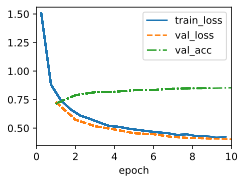

In [5]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## [**Concise Implementation**]

With high-level APIs, all we need to do is add a `Dropout` layer
after each fully connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When not in training mode,
the `Dropout` layer simply passes the data through during testing.


In [6]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

Next, we [**train the model**].


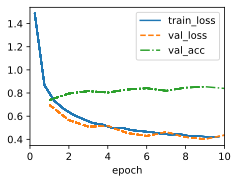

In [7]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool for avoiding overfitting. Often tools are used jointly.
Note that dropout is
used only during training:
it replaces an activation $h$ with a random variable with expected value $h$.


## Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
1. Why is dropout not typically used at test time?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?


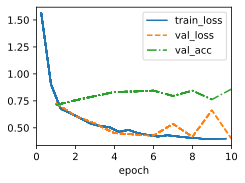

In [8]:
# Exercise 1
hparams1 = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.2, 'dropout_2':0.5, 'lr':0.8}
hparams2 = {'num_outputs': 10, 'num_hiddens_1':256, 'num_hidden2':256,
            'dropout_1':0.8, 'dropout_2':0.8, 'lr':0.2}

model = DropoutMLPScratch(**hparams1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

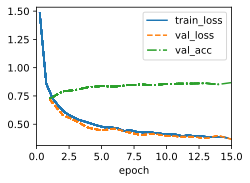

In [9]:
# Exercise 2: using dropout + increase number of epochs
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=15)
trainer.fit(model, data)

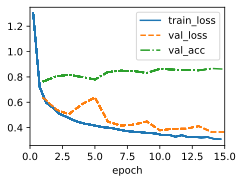

In [10]:
# Exercise 2: not using dropout + increase number of epochs
class MLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        H2 = self.relu(self.lin2(H1))
        return self.lin3(H2)

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256, 'lr':0.1}
model = MLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=15)
trainer.fit(model, data)

[Discussions](https://discuss.d2l.ai/t/101)


H1 variance: 0.2706
H2 variance: 0.5755
H1 variance: 0.2527
H2 variance: 0.5350
H1 variance: 0.2507
H2 variance: 0.5079
H1 variance: 0.2691
H2 variance: 0.5682
H1 variance: 0.2705
H2 variance: 0.5587
H1 variance: 0.2604
H2 variance: 0.5272
H1 variance: 0.2718
H2 variance: 0.5644
H1 variance: 0.2693
H2 variance: 0.5754
H1 variance: 0.2863
H2 variance: 0.6023
H1 variance: 0.2736
H2 variance: 0.5713
H1 variance: 0.2756
H2 variance: 0.5985
H1 variance: 0.2789
H2 variance: 0.5967
H1 variance: 0.2796
H2 variance: 0.6067
H1 variance: 0.2481
H2 variance: 0.5237
H1 variance: 0.2792
H2 variance: 0.6059
H1 variance: 0.2800
H2 variance: 0.6052
H1 variance: 0.2570
H2 variance: 0.5380
H1 variance: 0.2550
H2 variance: 0.5362
H1 variance: 0.2619
H2 variance: 0.5585
H1 variance: 0.2693
H2 variance: 0.5830
H1 variance: 0.2610
H2 variance: 0.5820
H1 variance: 0.2611
H2 variance: 0.5637
H1 variance: 0.2708
H2 variance: 0.5770
H1 variance: 0.2776
H2 variance: 0.6009
H1 variance: 0.2718
H2 variance: 0.5726


KeyboardInterrupt: 

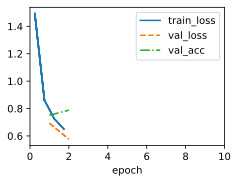

In [11]:
# Exercise 3
class DropoutMLPScratchWithVariance(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        print(f'H1 variance: {H1.var(dim=0).mean().item():.4f}')
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        print(f'H2 variance: {H2.var(dim=0).mean().item():.4f}')
        return self.lin3(H2)


hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratchWithVariance(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [16]:
# Exercise 5
import torch.optim as optim
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
optimizer = optim.SGD(model.parameters(), lr=hparams['lr'], weight_decay=1e-4)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10, optimizer = optimizer)
trainer.fit(model, data)

TypeError: Trainer.__init__() got an unexpected keyword argument 'optimizer'

In [ ]:
# Exercise 7: Gaussian Noise only
class GaussianNoiseMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, sigma=0.1, lr=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()
        self.sigma = sigma

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = H1 + torch.randn_like(H1) * self.sigma
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = H2 + torch.randn_like(H2) * self.sigma
        return self.lin3(H2)

In [21]:
# Exercise 7: Dropout + Gaussian Noise
p = 0.3
s = (p / (1 - p)) ** 0.5
class GaussianNoiseDropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, sigma=0.1, lr=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()
        self.sigma = sigma

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = H1 + torch.randn_like(H1) * s
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = H2 + torch.randn_like(H2) * s
        return self.lin3(H2)

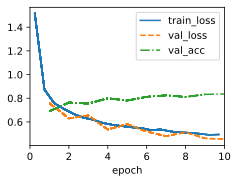

In [22]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256, 'lr':0.1}
model = GaussianNoiseDropoutMLP(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)